In [1]:
!pip install torch torchvision transformers evaluate datasets tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import Dataset, DatasetDict
import os
from PIL import Image
import numpy as np

def load_segmentation_dataset(image_dir, mask_dir):
    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpeg")])
    mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".png")])
    examples = []
    for image_path, mask_path in zip(image_paths, mask_paths):
        examples.append({"image": image_path, "mask": mask_path})

    return Dataset.from_dict({"image": [e["image"] for e in examples], "mask": [e["mask"] for e in examples]})

image_dir = "./drive/MyDrive/dataset/JPEGImages"
mask_dir = "./drive/MyDrive/dataset/SegmentationClass"

dataset = load_segmentation_dataset(image_dir, mask_dir)

train_test = dataset.train_test_split(test_size=0.2)
test_valid = train_test["test"].train_test_split(test_size=0.5)

final_dataset = DatasetDict({
    "train": train_test["train"],
    "validation": test_valid["train"],
    "test": test_valid["test"]
})

final_dataset.save_to_disk("segmentation_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/194 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/24 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25 [00:00<?, ? examples/s]

In [ ]:
from transformers import SegformerImageProcessor
from datasets import load_from_disk
import torch

# Load dataset
dataset = load_from_disk("segmentation_dataset")

# Initialize SegFormer ImageProcessor
image_processor = SegformerImageProcessor(do_reduce_labels=True)

def preprocess(example):
    # Load image and mask
    image = Image.open(example["image"]).convert("RGB")
    mask = Image.open(example["mask"]).convert("L")

    encoded_inputs = image_processor(images=image, segmentation_maps=mask, return_tensors="pt")
    return {
        "pixel_values": encoded_inputs["pixel_values"].squeeze(0),
        "labels": encoded_inputs["labels"].squeeze(0)
    }

# Preprocess
processed_dataset = dataset.map(preprocess, batched=False)

Map:   0%|          | 0/194 [00:00<?, ? examples/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Epoch [1/5], Train Loss: 0.1952, Val Loss: 0.0006
Epoch [2/5], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [3/5], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [4/5], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [5/5], Train Loss: 0.0000, Val Loss: 0.0000
Saved model architecture, weights and biases


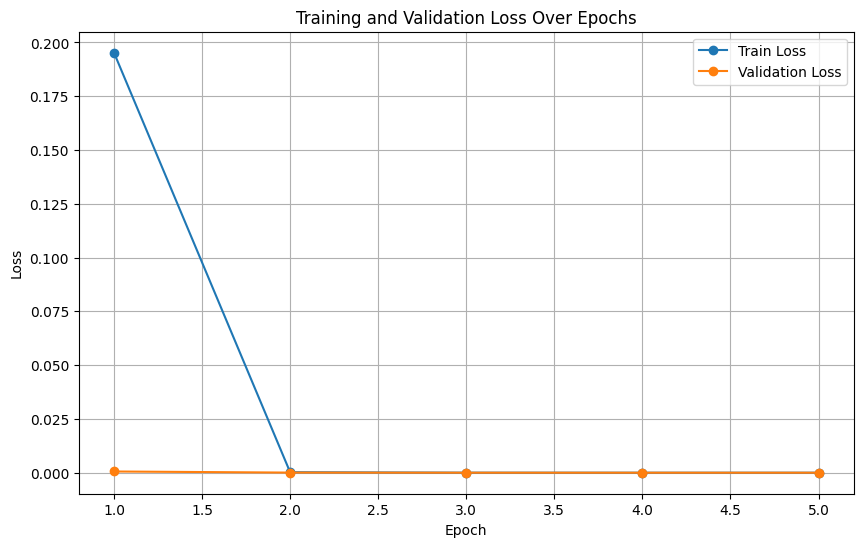

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset class
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_paths = sorted(os.listdir(image_dir))
        self.mask_paths = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_paths[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_paths[idx])

        # Load image and mask
        image = np.array(Image.open(image_path).convert("RGB"), dtype=np.float32) / 255.0
        mask = np.array(Image.open(mask_path), dtype=np.int64)
        if mask.ndim == 3 and mask.shape[2] == 3:  # Convert RGB masks to class indices
            mask = mask[..., 0]
        mask[mask > 3] = -1  # Ignore all labels > 3
        mask[mask < 0] = -1  # Ignore negative labels
        if self.transform:
            image, mask = self.transform(image, mask)

        return torch.tensor(image).permute(2, 0, 1), torch.tensor(mask)


# simple seg model
class SimpleSegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super(SimpleSegmentationModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, num_classes, kernel_size=2, stride=2),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize dataset and data loaders
train_dataset = SegmentationDataset("./drive/MyDrive/dataset/JPEGImages", "./drive/MyDrive/dataset/SegmentationClass")
val_dataset = SegmentationDataset("./drive/MyDrive/dataset/JPEGImages", "./drive/MyDrive/dataset/SegmentationClass")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

model = SimpleSegmentationModel(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)  # Ignore invalid pixels
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_losses = []
val_losses = []

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

torch.save(model.state_dict(), "simple_segmentation_model.pth") # saves weights and biases
torch.save(model, "simple_segmentation_model_complete.pth") # saves architecture
print("Saved model architecture, weights and biases")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()